<h1 align="center"> Chapter 5: Exploiting Generative Adversarial Networks for credit card fraud detection on simulated transactions </h1>


<h2> Our Goals </h2>
The purpose of this section is to deal with one of the most challenging problem of credit card fraud detection: the imbalance class problem. To do so we will employ two different methods: SMOTE and GAN oversampling. The former is a very popular method in literature that has already been used in many publications. The latter represents the focus of our thesis, and we will analyze it deeply to understand whether we can obtain acceptable results. The  train and test datasets have been created through a transactions simulator in a previous section. 
<h2> Index: </h2>

5.1 <b>Data overview and preparation (PART II) </b><br>
5.1.1 [Data Loading and Overview](#da) <br>
5.1.2 [Scaling](#da) <br>
5.1.3 [Train-test split](#da) <br>

5.2 <b>GAN OVERSAMPLING </b><br>
5.2.1 [GAN Creation](#da) <br>
5.2.2 [Analysis of the created dataset](#da) <br>
5.2.3 [Classification with GAN](#da) <br>
5.2.4 [Performance and Testing](#da) <br><br>

5.3 <b>SMOTE Oversampling</b><br>
5.3.1 [Classifiers ](#classifiers)<br>
5.3.2 [Performance and Testing](#logistic)<br><br> 

5.4 <b> Model comparison </b><br>

5.4.1 [Performance measures and matrices ](#logistic)<br><br>


# **5.1 DATA overview and preparation**

## 5.1.1 Data Loading and overview

As usual our first step  is to download our previously created functions and our datasets

In [ ]:
#mounting google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load shared functions
!curl -O https://github.com/leonardoimperit/thesis-timperi/shared_functions_imports.py
%run shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9  100     9    0     0     31      0 --:--:-- --:--:-- --:--:--    31


As usual, we first have to load our dataset: in this case the previously created synthetic transactions

In [ ]:
DIR_INPUT='/content/drive/MyDrive/Colab Notebooks/tesi/ready for repository/transformed_simulated data/' 

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


Load  files
CPU times: user 1.2 s, sys: 776 ms, total: 1.97 s
Wall time: 8.48 s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [ ]:
df = transactions_df.copy()

In [ ]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,1,1.0,57.16,1.0,57.16,1.0,57.16,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,1,1.0,81.51,1.0,81.51,1.0,81.51,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,1,1.0,146.00,1.0,146.00,1.0,146.00,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,1,1.0,64.49,1.0,64.49,1.0,64.49,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,1,1.0,50.99,1.0,50.99,1.0,50.99,0.0,0.0,0.0,0.0,0.0,0.0


We perform a brief Data Analysis to check that the upload was carried out correctly

In [ ]:
df.describe()

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
count,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06
mean,8.770770e+05,2.504011e+03,4.996733e+03,5.363230e+01,7.903234e+06,9.097260e+01,8.369272e-03,1.882388e-02,2.898176e-01,1.738552e-01,3.560578e+00,5.362741e+01,1.864045e+01,5.361508e+01,7.174940e+01,5.360278e+01,9.597419e-01,5.062488e-03,6.607971e+00,7.909228e-03,2.640982e+01,7.538655e-03
std,5.063811e+05,1.445987e+03,2.886101e+03,4.232649e+01,4.565172e+06,5.283709e+01,9.110012e-02,2.113263e-01,4.536777e-01,3.789850e-01,1.847658e+00,3.504634e+01,7.883447e+00,3.046794e+01,3.216790e+01,2.933973e+01,1.019762e+00,6.764030e-02,3.306587e+00,7.122464e-02,1.141545e+01,5.620902e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-7.105427e-15,1.000000e+00,2.000000e-02,1.000000e+00,2.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.385385e+05,1.252000e+03,2.502000e+03,2.101000e+01,3.940846e+06,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.571000e+01,1.300000e+01,2.824600e+01,4.700000e+01,2.867894e+01,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00
50%,8.770770e+05,2.506000e+03,4.994000e+03,4.464000e+01,7.902670e+06,9.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,4.925333e+01,1.900000e+01,5.236450e+01,7.600000e+01,5.302643e+01,1.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.700000e+01,0.000000e+00
75%,1.315616e+06,3.765000e+03,7.495000e+03,7.695000e+01,1.186566e+07,1.370000e+02,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,5.000000e+00,7.600000e+01,2.400000e+01,7.688119e+01,9.800000e+01,7.760878e+01,2.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,3.400000e+01,0.000000e+00
max,1.754154e+06,4.999000e+03,9.999000e+03,2.628000e+03,1.581120e+07,1.820000e+02,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01,1.377075e+03,5.200000e+01,5.092833e+02,1.570000e+02,2.910900e+02,1.000000e+01,1.000000e+00,2.800000e+01,1.000000e+00,8.200000e+01,1.000000e+00


We check the proportion of frauds and no frauds

In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['TX_FRAUD'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['TX_FRAUD'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.16 % of the dataset
Frauds 0.84 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

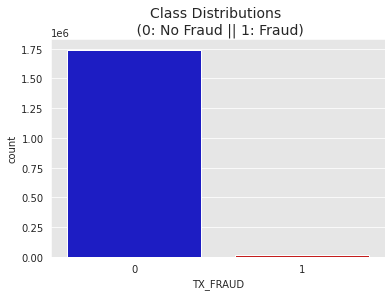

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('TX_FRAUD', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Here we give a look to the 2 easiest to interpret variables: Amount and Time.

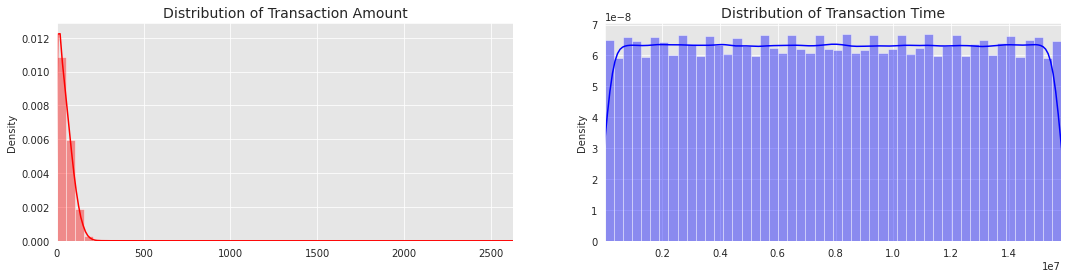

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['TX_AMOUNT'].values
time_val = df['TX_TIME_SECONDS'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

## 5.1.2. DATA PREPARATION: SCALING


The rest of the data preparation has already been carried out in a previous notebook. Here we perform scaling of the non-binary variables as it is fundamental for our generative adversarial network

In [ ]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


In [ ]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler
def scaleData(dataset,features):
    scaler = StandardScaler()
    scaler.fit(dataset[features])
    dataset[features]=scaler.transform(dataset[features])
    
    return dataset

In [ ]:
nonbinary_input_features=['TX_AMOUNT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


In [ ]:
scaled_dataset = scaleData(df,nonbinary_input_features)

In [ ]:
df = scaled_dataset[input_features]
df[output_feature]= scaled_dataset[output_feature]

In [ ]:
df

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD
0,0.083345,1,1,-1.385851,0.100798,-2.237657,0.116349,-2.199379,0.121242,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
1,0.658635,1,1,-1.385851,0.795592,-2.237657,0.915550,-2.199379,0.951175,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
2,2.182267,1,1,-1.385851,2.635728,-2.237657,3.032202,-2.199379,3.149220,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
3,0.256523,1,1,-1.385851,0.309949,-2.237657,0.356930,-2.199379,0.371074,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
4,-0.062427,1,1,-1.385851,-0.075255,-2.237657,-0.086159,-2.199379,-0.089053,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,0.014357,1,0,-0.844625,0.617828,-0.842328,0.440871,0.007790,0.542552,0.039478,-0.074844,-0.788720,-0.111046,0.139300,-0.134118,0
1754151,-1.238050,1,0,-1.385851,-1.495090,0.299305,-1.031946,0.660615,-0.982355,0.039478,-0.074844,0.723413,-0.111046,1.102907,-0.134118,0
1754152,-1.110707,1,0,0.779052,-1.319950,0.299305,-1.516828,-0.209818,-1.558922,0.039478,-0.074844,-0.486294,-0.111046,0.577303,-0.134118,0
1754153,0.041763,1,0,-0.303399,1.343058,-0.334936,1.753891,-0.645034,1.680890,0.039478,-0.074844,-0.183867,-0.111046,0.139300,-0.134118,0


## 5.1.3 Train and Test Splitting

In this section we perform a standard Train/Test splitting. We divide our test set to be 20% of the total dataset. Since our dataset contains a sufficiently big number of transactions, this should be enough to evaluate our models.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

print('No Frauds', round(df['TX_FRAUD'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['TX_FRAUD'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('TX_FRAUD', axis=1)
y = df['TX_FRAUD']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
original_Xtrain_nofraudindex = original_ytrain ==0
original_Xtrain_fraudindex = original_ytrain ==1
original_Xtest_nofraudindex = original_ytest ==0
original_Xtest_fraudindex = original_ytest ==1


#creating dataframes (it will become more useful later)
original_Xtrain_df = pd.DataFrame(original_Xtrain)
original_Xtrain_df.columns = X.columns
original_Xtest_df = pd.DataFrame(original_Xtest)
original_Xtest_df.columns = pd.DataFrame(original_Xtest).columns
original_Xtrain_df_fraud = original_Xtrain_df.iloc[original_Xtrain_fraudindex]
original_Xtrain_df_nofraud = original_Xtrain_df.iloc[original_Xtrain_nofraudindex]
original_Xtest_df_fraud = original_Xtest_df.iloc[original_Xtest_fraudindex]
original_Xtest_df_nofraud = original_Xtest_df.iloc[original_Xtest_nofraudindex]


# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.16 % of the dataset
Frauds 0.84 % of the dataset
Train: [ 350197  350198  350199 ... 1754152 1754153 1754154] Test: [     0      1      2 ... 424727 425176 425184]
Train: [      0       1       2 ... 1754152 1754153 1754154] Test: [350197 350198 350199 ... 768566 768653 768685]
Train: [      0       1       2 ... 1754152 1754153 1754154] Test: [ 701101  701102  701103 ... 1095208 1095343 1095476]
Train: [      0       1       2 ... 1754152 1754153 1754154] Test: [1052163 1052164 1052165 ... 1424801 1424859 1425018]
Train: [      0       1       2 ... 1424801 1424859 1425018] Test: [1403110 1403111 1403112 ... 1754152 1754153 1754154]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.9916313 0.0083687]
[0.99162845 0.00837155]


The proportion of frauds is similar on the test and train set. This means that we performed our splitting correctly

# **5.2 GAN OVERSAMPLING**
We arrive here to the center of our analysis. In the first section we will try to create and train a Generative Adversarial Network. In the second section we will employ as an oversampling method with the aim to solve our imbalance classification problem


## 5.2.1 Creation of a Generative Adversarial Network

We start by importing the required packages. We will use tensorflow keras developed by google, which runs the google colab platform

In [ ]:
import tensorflow as tf
from random import randint
import sys

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
# example of loading the mnist dataset

Our first step is the creation of a Discriminator class. The network here is just a preliminary one with default loss and activation functions and just 3 layers.

In [ ]:
class Discriminator(object):
       def __init__(self, number_features = 15,
                    latent_size=100):
           # Initialize Variables
            self.CAPACITY = number_features
            self.SHAPE = (number_features,)
            self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
            self.Discriminator = self.model()
            self.Discriminator.compile(loss='binary_crossentropy',
                               optimizer=self.OPTIMIZER, metrics=['accuracy'] )
            self.Discriminator.summary()
       def model(self):
           # Build the binary classifier and return it
            model = Sequential()
            model.add(Flatten(input_shape=self.SHAPE))
            model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
            model.add(Dense(int(self.CAPACITY/2)))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
            model.add(Dense(1, activation='sigmoid'))
            return model
       def summary(self):
            return self.Discriminator.summary()
           # Prints the Model Summary to the Screen

The same is true here for our generator. It is a simple neural network with the number of layers as parameters. Here 4 is set as the default. Loss functions and optimnizers are still default ones.

In [ ]:
class Generator(object):
       def __init__(self, number_features = 15,
                    latent_size=100, num_blocks = 4):
            # Initialize Variables
           self.number_features = number_features 
           self.num_blocks = num_blocks
           self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
           self.LATENT_SPACE_SIZE = latent_size
           self.latent_space = np.random.normal(0,1,
                                           (self.LATENT_SPACE_SIZE,))
           self.Generator = self.model()
           self.Generator.compile(loss='binary_crossentropy',
                                  optimizer=self.OPTIMIZER)
           self.Generator.summary()
            
       def model(self, block_starting_size=128):
           model = Sequential()
           block_size = block_starting_size
           model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
           model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
           model.add(BatchNormalization(momentum=0.8))
           for i in range(self.num_blocks-1):
                            block_size = block_size * 2
                            model.add(Dense(block_size))
                            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
                            model.add(BatchNormalization(momentum=0.8))
           model.add(Dense(self.number_features , activation='tanh'))
           model.add(Reshape((self.number_features, )))
           return model
           # Build the generator model and returns it
       def summary(self):
           return self.Generator.summary()
           # Prints the Model Summary to the screen
       #def save_model(self):
           # Saves the model structure to a file in the data folder

Finally our GAN network is created! It is defined as just the sum of the Discriminator and the Generator networks. 

In [ ]:
class GAN(object):
       def __init__(self, discriminator,generator):
           self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
           self.Generator = generator
           self.Discriminator = discriminator
           self.Discriminator.trainable = False
           self.gan_model = self.model()
           self.gan_model.compile(loss='binary_crossentropy',
                                  optimizer=self.OPTIMIZER)
           self.gan_model.summary()

           # Initialize Variables
       def model(self):
           model = Sequential()
           model.add(self.Generator)
           model.add(self.Discriminator)
           return model

           # Build the adversarial model and return it
        
       def summary(self):
           return gan_model.summary()
           # Prints the Model Summary to the Screen

Here we have the Trainer Class. What is very important here is to define it in a way that the GAN can learn in an adversarial way. For each step we will have that when the generator learns the discriminator stop learning and viceversa. If we don't employ this simple strategy it will be impossible for the system to converge and provide acceptable results.

In [ ]:
class Trainer:
         def __init__(self, X_trainer, number_features = 15,latent_size=100, epochs =5000, batch=32, num_blocks = 4):
          self.X_train = np.array(X_trainer).copy()
          self.number_features = number_features 
          self.EPOCHS = epochs
          self.BATCH = batch
          self.LATENT_SPACE_SIZE = latent_size
          self.generator = Generator(number_features=self.number_features, latent_size=self.LATENT_SPACE_SIZE, num_blocks = num_blocks )
          self.discriminator = Discriminator(number_features =self.number_features)
          self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)
          self.load_data()
         def sample_latent_space(self, instances):
                    return np.random.normal(0, 1,(instances,self.LATENT_SPACE_SIZE))
         def train(self):
                d_loss_list = np.array([])
                g_loss_list = np.array([])
                for e in range(self.EPOCHS):
                  # Grab a batch
                    count_real_frauds = int(self.BATCH/2)
                    starting_index = randint(0, (len(self.X_train)-count_real_frauds))
                    real_frauds_raw = self.X_train[starting_index : (starting_index +count_real_frauds)]
                    x_real_frauds = real_frauds_raw.reshape( count_real_frauds, self.number_features)
                    y_real_labels = np.ones([count_real_frauds,1])
                    # Grab Generated Images for this training batch
                    latent_space_samples = self.sample_latent_space(count_real_frauds)
                    x_generated_frauds = self.generator.Generator.predict(latent_space_samples)
                    y_generated_labels = np.zeros([self.BATCH-count_real_frauds,1])
                    # Combine to train on the discriminator
                    x_batch = np.concatenate( [x_real_frauds, x_generated_frauds] )
                    y_batch = np.concatenate( [y_real_labels, y_generated_labels] )
                    # Now, train the discriminator with this batch
                    discriminator_loss  = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
                    d_loss_list = np.append(d_loss_list,discriminator_loss)
                    # Generate Noise
                    x_latent_space_samples = self.sample_latent_space(self.BATCH)
                    y_generated_labels = np.ones([self.BATCH,1])
                    generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)
                    g_loss_list = np.append(g_loss_list,generator_loss)
                    print ('Epoch:' + str(int(e)) + ', [Discriminator :: Loss:' + str(discriminator_loss)+'], [ Generator :: Loss:'+str(generator_loss)+']')
                return d_loss_list, g_loss_list
         def load_data(self):
                      self.X_train = np.float32(self.X_train)
                      self.X_train = np.expand_dims(self.X_train, axis=2)
                      return

The parameters are set in such a way that maximize  our performance measures. This were obtaines with a reference to theory and after some trial-and-error. We are still in a preliminary phase.

In [ ]:
#!/usr/bin/env python3
NUMBER_FEATURES  = 15
LATENT_SPACE_SIZE = 100
EPOCHS = 2000
BATCH = 64
NUM_BLOCKS = 6
trainer = Trainer(X_trainer = original_Xtrain_df_fraud,number_features = NUMBER_FEATURES, latent_size=LATENT_SPACE_SIZE, epochs =EPOCHS, batch=BATCH, num_blocks = NUM_BLOCKS)
d_loss, g_loss = trainer.train()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)              

This graph shows the behaviour of our generative and discriminative loss. We can see that there are some problems in the discriminator with relevant oscillation. However we can see that the scale of the difference is very small and overall the system does not diverge, despite the relatively significant variance through the epochs. Moreover we can see that the discriminative loss oscillate around 0.5, that is exactly the Nash Equilibrium that we expect for this type of networks.

Text(0, 0.5, 'Loss')

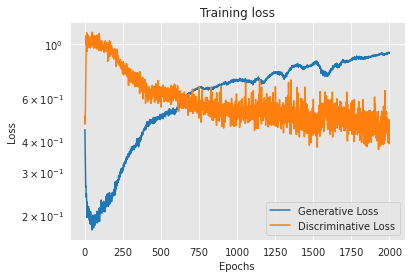

In [ ]:
import pandas as pd
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

## 5.2.2 Creation of the oversampled dataset employing the trained GAN

The sample_latent_space function is fundamental to create variation in the generated frauds

In [ ]:
def sample_latent_space(instances, latent_space_size):
                    return np.random.normal(0, 1,(instances,latent_space_size))

In [ ]:

#for a balanced dataset we need to generate nofraud_df.shape[0] - fraud_df.shape[0] new transactions
number_new_frauds = original_Xtrain_df_nofraud.shape[0] - original_Xtrain_df_fraud.shape[0]
latent_space_samples = sample_latent_space(number_new_frauds,LATENT_SPACE_SIZE)
new_generated_frauds = trainer.generator.Generator.predict(latent_space_samples)

In [ ]:
new_generated_frauds = np.reshape(new_generated_frauds,(number_new_frauds,15))
new_frauds_gan = pd.DataFrame(new_generated_frauds)
#adding back the class
new_frauds_gan['TX_FRAUD'] = 1
#adding back the column names
new_frauds_gan.columns = df.columns

In [ ]:
original_nofraud_dftrain_with_class = original_Xtrain_df_nofraud.copy()
original_nofraud_dftrain_with_class['TX_FRAUD']=0
original_fraud_dftrain_with_class = original_Xtrain_df_fraud.copy()
original_fraud_dftrain_with_class['TX_FRAUD']=1
new_balanced_dataset_gan = pd.concat([original_nofraud_dftrain_with_class, original_fraud_dftrain_with_class, new_frauds_gan], axis = 0 )
new_balanced_dataset_gan.head() 

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD
0,0.083345,1.0,1.0,-1.385851,0.100798,-2.237657,0.116349,-2.199379,0.121242,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
1,0.658635,1.0,1.0,-1.385851,0.795592,-2.237657,0.915550,-2.199379,0.951175,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
2,2.182267,1.0,1.0,-1.385851,2.635728,-2.237657,3.032202,-2.199379,3.149220,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
3,0.256523,1.0,1.0,-1.385851,0.309949,-2.237657,0.356930,-2.199379,0.371074,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
4,-0.062427,1.0,1.0,-1.385851,-0.075255,-2.237657,-0.086159,-2.199379,-0.089053,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0


In [ ]:
new_balanced_dataset_gan

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD
0,0.083345,1.000000,1.000000,-1.385851,0.100798,-2.237657,0.116349,-2.199379,0.121242,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
1,0.658635,1.000000,1.000000,-1.385851,0.795592,-2.237657,0.915550,-2.199379,0.951175,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
2,2.182267,1.000000,1.000000,-1.385851,2.635728,-2.237657,3.032202,-2.199379,3.149220,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
3,0.256523,1.000000,1.000000,-1.385851,0.309949,-2.237657,0.356930,-2.199379,0.371074,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
4,-0.062427,1.000000,1.000000,-1.385851,-0.075255,-2.237657,-0.086159,-2.199379,-0.089053,-0.941143,-0.074844,-1.998427,-0.111046,-2.313516,-0.134118,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379831,1.000000,0.999979,0.999992,-1.000000,0.999854,1.000000,1.000000,-1.000000,-0.755616,-0.461701,1.000000,1.000000,0.999537,-1.000000,1.000000,1
1379832,1.000000,1.000000,-1.000000,0.998701,1.000000,-0.996291,-1.000000,1.000000,-1.000000,0.999908,0.999177,-1.000000,0.999984,1.000000,1.000000,1
1379833,1.000000,1.000000,-1.000000,0.754452,1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,0.998538,0.999998,1.000000,1.000000,1
1379834,0.999825,-1.000000,0.998860,-0.579815,0.999991,-1.000000,1.000000,0.507824,1.000000,-1.000000,1.000000,-1.000000,0.999120,0.108170,0.999999,1


We observe that the total  number of transactions and the values of the generated transactions correspond with what we expect from the GAN oversampling.

Indeed, here we can see how the distribution of classes correspond to 50%. Later we will change this value to understand how this will impact our model performance

Distribution of the Classes in the gan balanced dataset
1    0.5
0    0.5
Name: TX_FRAUD, dtype: float64


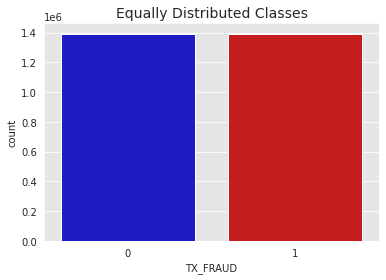

In [ ]:
print('Distribution of the Classes in the gan balanced dataset')
print(new_balanced_dataset_gan['TX_FRAUD'].value_counts()/len(new_balanced_dataset_gan))



sns.countplot('TX_FRAUD', data=new_balanced_dataset_gan, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## 5.2.3 Classifiers with GAN without Cross Validation

We first start with a default Logistic regression to understand whether everything seems to work properly

In [ ]:
X_train_gan = np.array(new_balanced_dataset_gan.drop('TX_FRAUD', axis = 1))
y_train_gan = np.array(new_balanced_dataset_gan['TX_FRAUD'])

In [ ]:
from sklearn.linear_model import LogisticRegression
log_clf= LogisticRegression()
log_clf.fit(X_train_gan, y_train_gan)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Text(190.6800000000001, 0.5, 'Predicted label')

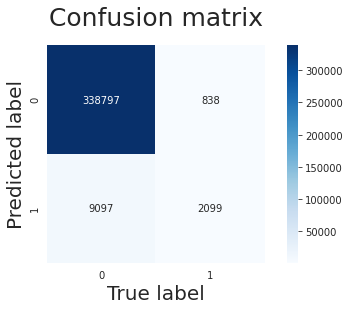

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred_gan = log_clf.predict(original_Xtest)

mat = confusion_matrix(original_ytest, y_pred_gan)

plt.figure(figsize=(8,4))
ax= sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
ax.set_ylim([2,0])
plt.title("Confusion matrix", pad=20, fontsize=25,  FontName='Times New Roman')
plt.xlabel('True label',fontsize=20, FontName='Times New Roman')
plt.ylabel('Predicted label',fontsize=20, FontName='Times New Roman')

In [ ]:
import sklearn.metrics as metrics
print("Classification Report:")
print(metrics.classification_report(original_ytest, y_pred_gan))
print ("GAN - Train Accuracy:", metrics.accuracy_score(y_train_gan, log_clf.predict(X_train_gan)))
print ("GAN - Test Accuracy:", metrics.accuracy_score(original_ytest, y_pred_gan))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    347894
           1       0.19      0.71      0.30      2937

    accuracy                           0.97    350831
   macro avg       0.59      0.84      0.64    350831
weighted avg       0.99      0.97      0.98    350831

GAN - Train Accuracy: 0.9796145388694865
GAN - Test Accuracy: 0.9716815218723545


With a precision of 0.17 and a recall of 0.55 we can observe that the performance is not the best, but we are still doing better than a random classifier. We will here try with different models.

In [ ]:
def fit_model_and_get_predictions(classifier, xtrain, ytrain, xtest,ytest):

    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(xtrain, ytrain)
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict(xtest)
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict(xtrain)

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [ ]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_gan_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], X_train_gan, y_train_gan, original_Xtest, original_ytest)
    fitted_models_and_predictions_gan_dictionary[classifier_name]=model_and_predictions


In [ ]:
def performance_assessment(predictions,original_ytest, rounded =True):
    
    AUC_ROC = metrics.roc_auc_score(predictions, original_ytest)
    precision = metrics.precision_score(predictions, original_ytest)
    recall = metrics.recall_score(predictions, original_ytest)
    f1_score = metrics.f1_score(predictions, original_ytest)
    
    performances = pd.DataFrame([[AUC_ROC, precision, recall,f1_score]], 
                           columns=['AUC ROC',' Precision',' Recall', 'f1_score'])
    
    if rounded:
        performances = performances.round(3)
    
    return performances
def performance_assessment_model_collection_gan(fitted_models_and_predictions_dictionary, 
                                            test, 
                                            type_set='test'):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions, original_ytest)
        performances_model.index=[classifier_name + '_gan']
        
        performances=performances.append(performances_model)
        
    return performances



This table display our generated performance measures. It is evident that for this problem the XGBoost_gan with oversampling perform much better than Logistic Regression on the same dataset.

In [ ]:
# performances on test set
gan_performances=performance_assessment_model_collection_gan(fitted_models_and_predictions_gan_dictionary, original_ytest, 
                                                        type_set='test')
gan_performances

,AUC ROC,Precision,Recall,f1_score
Logistic regression_gan,0.593,0.715,0.187,0.297
XGBoost_gan,0.973,0.635,0.949,0.761


here we create a dictionary for our matrices in order to be able to show them together with the smote oversampling.

In [ ]:
confusion_matrix_gan_dictionary={}
for classifier_name, model_and_predictions in fitted_models_and_predictions_gan_dictionary.items():
        predictions=model_and_predictions['predictions_test']
        confusion_matrix_gan_dictionary[classifier_name] = confusion_matrix(original_ytest, model_and_predictions['predictions_test'])

It is now time to show and anaylize our matrices

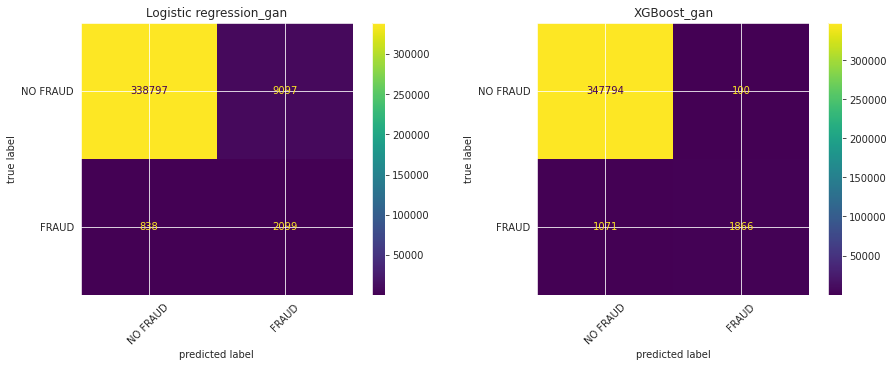

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

labels = ['NO FRAUD', 'FRAUD']
for classifier_name, ax in zip(fitted_models_and_predictions_gan_dictionary.keys(),axes.flatten()):
    cf_matrix = confusion_matrix_gan_dictionary[classifier_name]
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=labels)
    disp.plot(xticks_rotation=45, ax=ax, values_format = 'g' )
    disp.ax_.set_title(classifier_name + '_gan')
    disp.ax_.set_xlabel('predicted label')
    disp.ax_.set_ylabel('true label')
plt.show()

# **5.3 SMOTE OVERSAMPLING**

## 5.3.1 IMPLEMENTING SMOTE and classification

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [ ]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_smote_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], Xsm_train, ysm_train, original_Xtest, original_ytest)
    fitted_models_and_predictions_smote_dictionary[classifier_name]=model_and_predictions


## 5.3.2 Model performance with SMOTE oversampling

In [ ]:
def performance_assessment_model_collection_smote(fitted_models_and_predictions_dictionary, 
                                            test, 
                                            type_set='test'):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions, original_ytest)
        performances_model.index=[classifier_name + '_smote']
        
        performances=performances.append(performances_model)
        
    return performances



In [ ]:
# performances on test set
smote_performances=performance_assessment_model_collection_smote(fitted_models_and_predictions_smote_dictionary, original_ytest, 
                                                        type_set='test')
smote_performances

,AUC ROC,Precision,Recall,f1_score
Logistic regression_smote,0.560,0.783,0.122,0.211
XGBoost_smote,0.728,0.704,0.459,0.556


In [ ]:
confusion_matrix_smote_dictionary={}
for classifier_name, model_and_predictions in fitted_models_and_predictions_smote_dictionary.items():
        predictions=model_and_predictions['predictions_test']
        confusion_matrix_smote_dictionary[classifier_name] = confusion_matrix(original_ytest, model_and_predictions['predictions_test'])

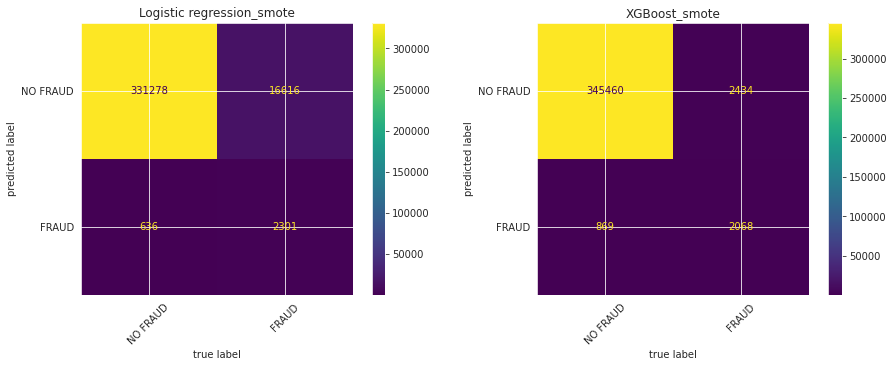

In [ ]:

fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for classifier_name, ax in zip(fitted_models_and_predictions_smote_dictionary.keys(),axes2.flatten()):
    cf_matrix = confusion_matrix_smote_dictionary[classifier_name]
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=labels)
    disp.plot(xticks_rotation=45, ax=ax, values_format = 'g' )
    disp.ax_.set_title(classifier_name + '_smote')
    disp.ax_.set_xlabel('true label')
    disp.ax_.set_ylabel('predicted label')
plt.show()

# 5.4 Model Comparison

In this final section we compare model comparison with and without smote, to understand which provides better results and more efficient results

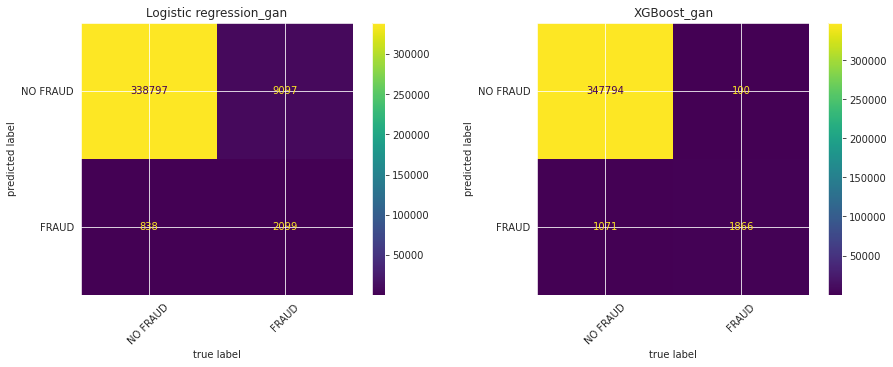

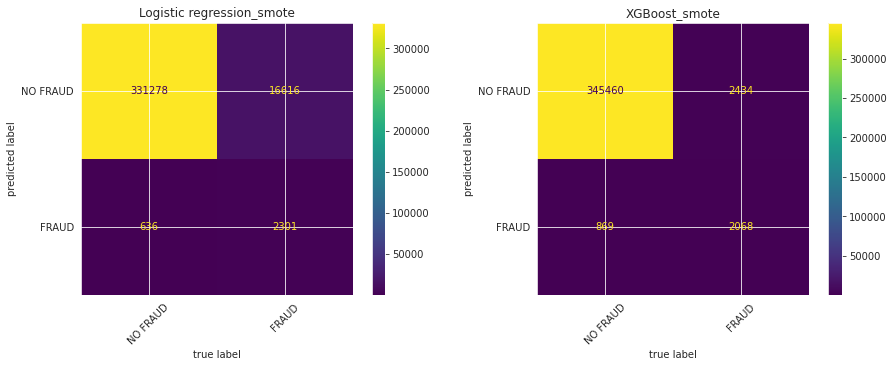

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

labels = ['NO FRAUD', 'FRAUD']
for classifier_name, ax in zip(fitted_models_and_predictions_smote_dictionary.keys(),axes.flatten()):
    cf_matrix = confusion_matrix_gan_dictionary[classifier_name]
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=labels)
    disp.plot(xticks_rotation=45, ax=ax, values_format = 'g' )
    disp.ax_.set_title(classifier_name + '_gan')
    disp.ax_.set_xlabel('true label')
    disp.ax_.set_ylabel('predicted label')
plt.show()
fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for classifier_name, ax in zip(fitted_models_and_predictions_smote_dictionary.keys(),axes2.flatten()):
    cf_matrix = confusion_matrix_smote_dictionary[classifier_name]
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=labels)
    disp.plot(xticks_rotation=45, ax=ax, values_format = 'g' )
    disp.ax_.set_title(classifier_name + '_smote')
    disp.ax_.set_xlabel('true label')
    disp.ax_.set_ylabel('predicted label')
plt.show()


In [ ]:
performances_total = gan_performances.copy()
performances_total = performances_total.append(smote_performances)
performances_total

,AUC ROC,Precision,Recall,f1_score
Logistic regression_gan,0.593,0.715,0.187,0.297
XGBoost_gan,0.973,0.635,0.949,0.761
Logistic regression_smote,0.560,0.783,0.122,0.211
XGBoost_smote,0.728,0.704,0.459,0.556
